In [1]:
%matplotlib inline
import sys
sys.path.append('/home/ubuntu/tools/python-genomics')
import Scanpyplus
from importlib import reload
import pandas as pd
import scanpy.api as sc
import anndata
import os
import numpy as np
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80,dpi_save=300,color_map='PuRd')
sc.logging.print_version_and_date()

import matplotlib
import matplotlib.pyplot as plt
plt.show()
matplotlib.rcParams.update({'figure.figsize': (8,8)})
import pandasPlus

/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Running Scanpy 1.4.4.post1, on 2020-03-09 23:12.


## Follow Scanpy's tutorial as usual

... reading from cache file cache/filtered_gene_bc_matrices-hg19-matrix.h5ad
filtered out 19024 genes that are detectedin less than 3 cells
normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:07)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, cat

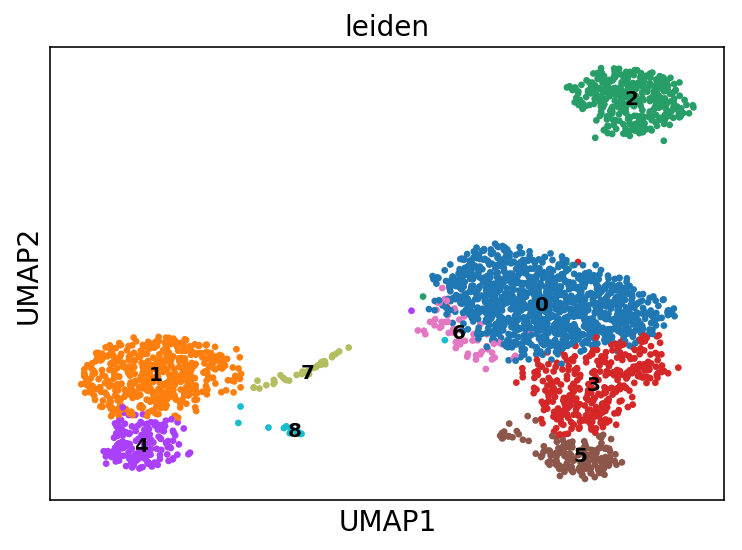

In [2]:
#Scanpy tutorial is here https://icb-scanpy-tutorials.readthedocs-hosted.com/en/latest/pbmc3k.html
adata = sc.read_10x_mtx(
    './filtered_gene_bc_matrices/hg19/',# the directory with the `.mtx` file
    var_names='gene_symbols',  # use gene symbols for the variable names
    cache=True)     
adata.var_names_make_unique()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3) 

mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.3)

bdata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(bdata, ['n_counts', 'percent_mito'])
sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack')
sc.pp.neighbors(bdata, n_neighbors=10, n_pcs=40)
sc.tl.umap(bdata)
sc.tl.leiden(bdata)
sc.pl.umap(bdata, color='leiden', legend_loc='on data')

In [3]:
bdata

AnnData object with n_obs × n_vars = 2638 × 2250 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

# Perform DeepTree selection

Trying to set attribute `.var` of view, making a copy.


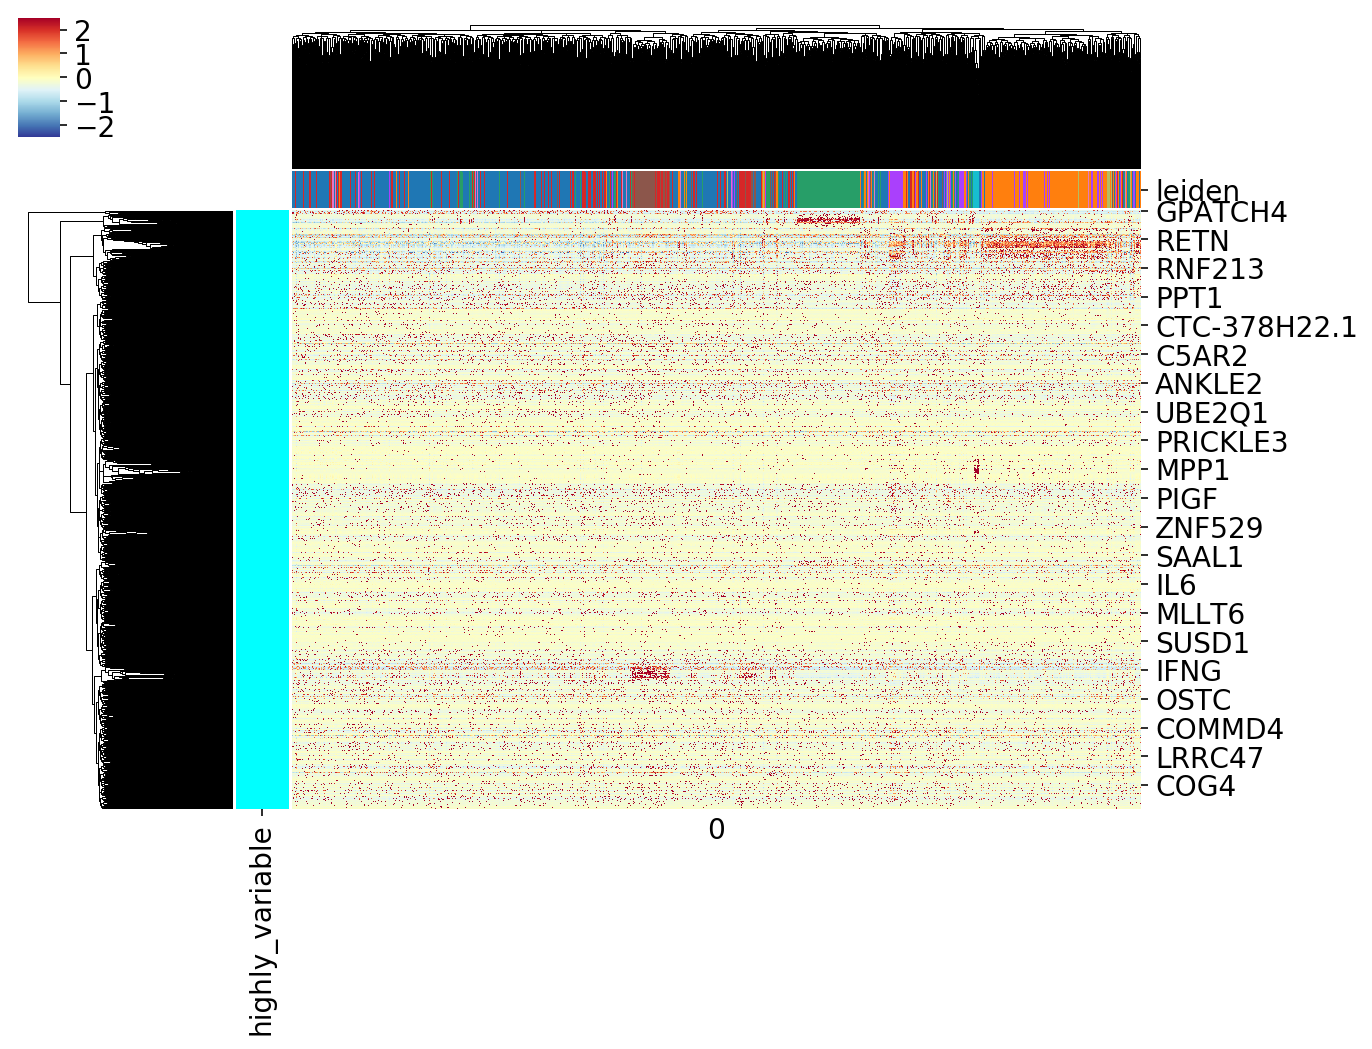

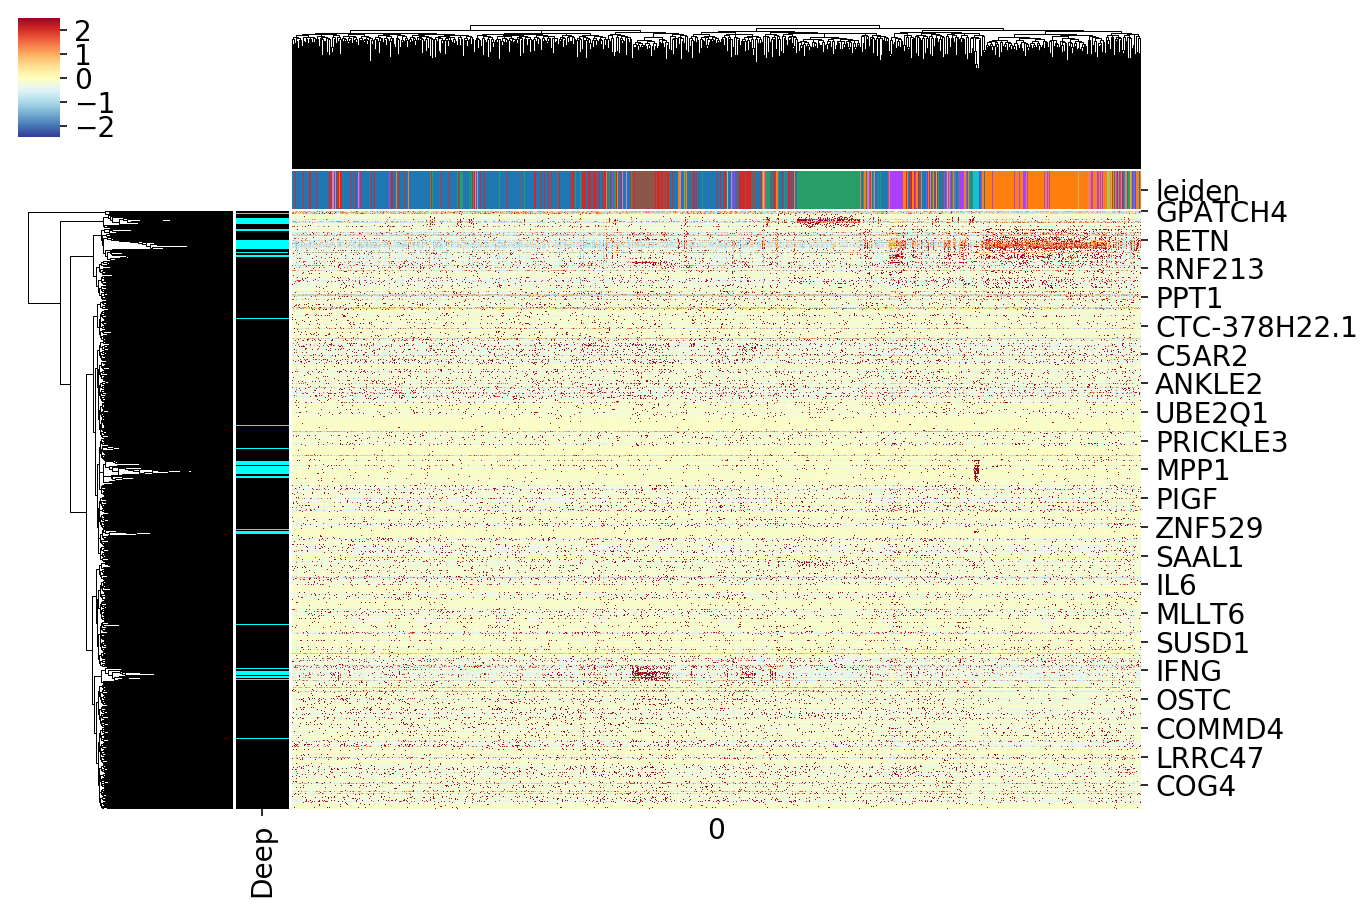

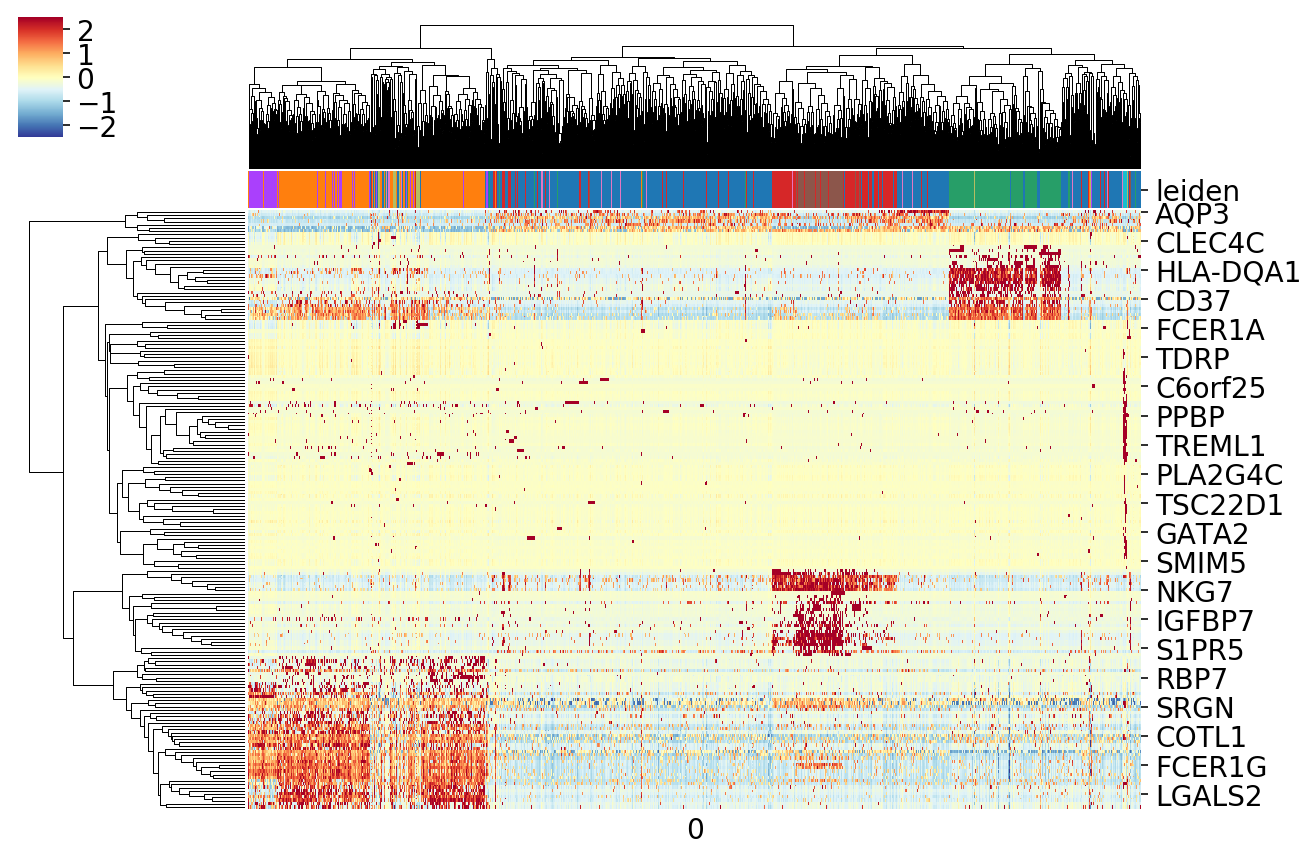

In [4]:
[bdata, output1, output2, output3] = Scanpyplus.DeepTree(bdata,
                           MouseC1ColorDict2={False:'#000000',True:'#00FFFF'}, #This specifies rowlabel colors
                           cell_type='leiden', #This specieis the .obs variable you are interested in
                           row_cluster=True,col_cluster=True #This lets the function clusters the rows and columns
                           )

This generates three clustermaps stored in output1, output2 and output3

The first clustermap is an overview of the top 4000 highly-variable genes. As you can see only a small subset of them show coherent patterns. Color bars on the top shows cell cluster IDs from the previous straight forward clustering.

The second clustermap highlights the DeepTree-selected genes using cyan on the left. The selection gets rid of most sporadic noises.

The third clustermap shows how cell clustering will improve if we only use the DeepTree-selected genes

In [5]:
bdata.var['Deep']

7SK-2     False
AAGAB     False
AAR2      False
AATF      False
ABCB1     False
          ...  
ZSWIM6    False
ZSWIM8    False
ZUFSP     False
ZWINT      True
ZYX       False
Name: Deep, Length: 2250, dtype: bool

## Evaluate the DeepTree-selected genes

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


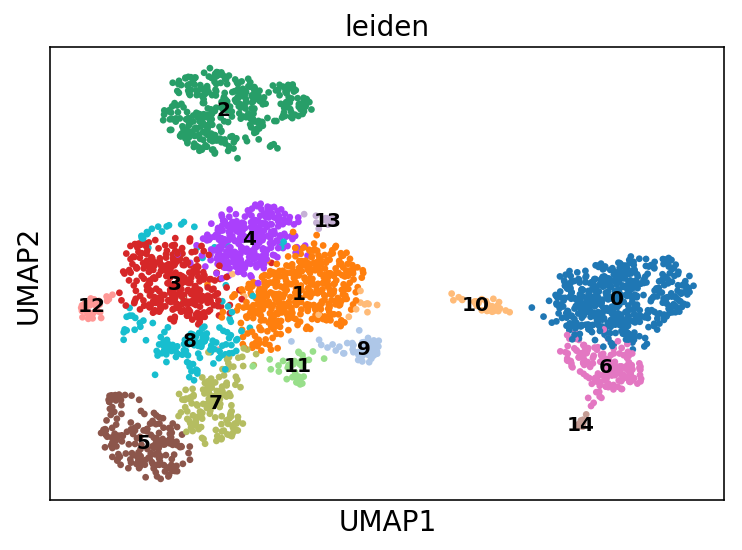

In [6]:
#Now use these genes to replace highly-variable genes for data analysis.

bdata=bdata[:,bdata.var['Deep']]
sc.tl.pca(bdata, svd_solver='arpack')
sc.pp.neighbors(bdata, n_neighbors=10, n_pcs=40)
sc.tl.umap(bdata)
sc.tl.leiden(bdata)
sc.pl.umap(bdata, color='leiden', legend_loc='on data')

As we can see more clusters emerge. But are they interesting? Let's check

In [7]:
#transfer the coordinates and clustering info back to the full dataset
adata.obsm['X_umap']=bdata.obsm['X_umap']
adata.obs['leiden']=bdata.obs['leiden']

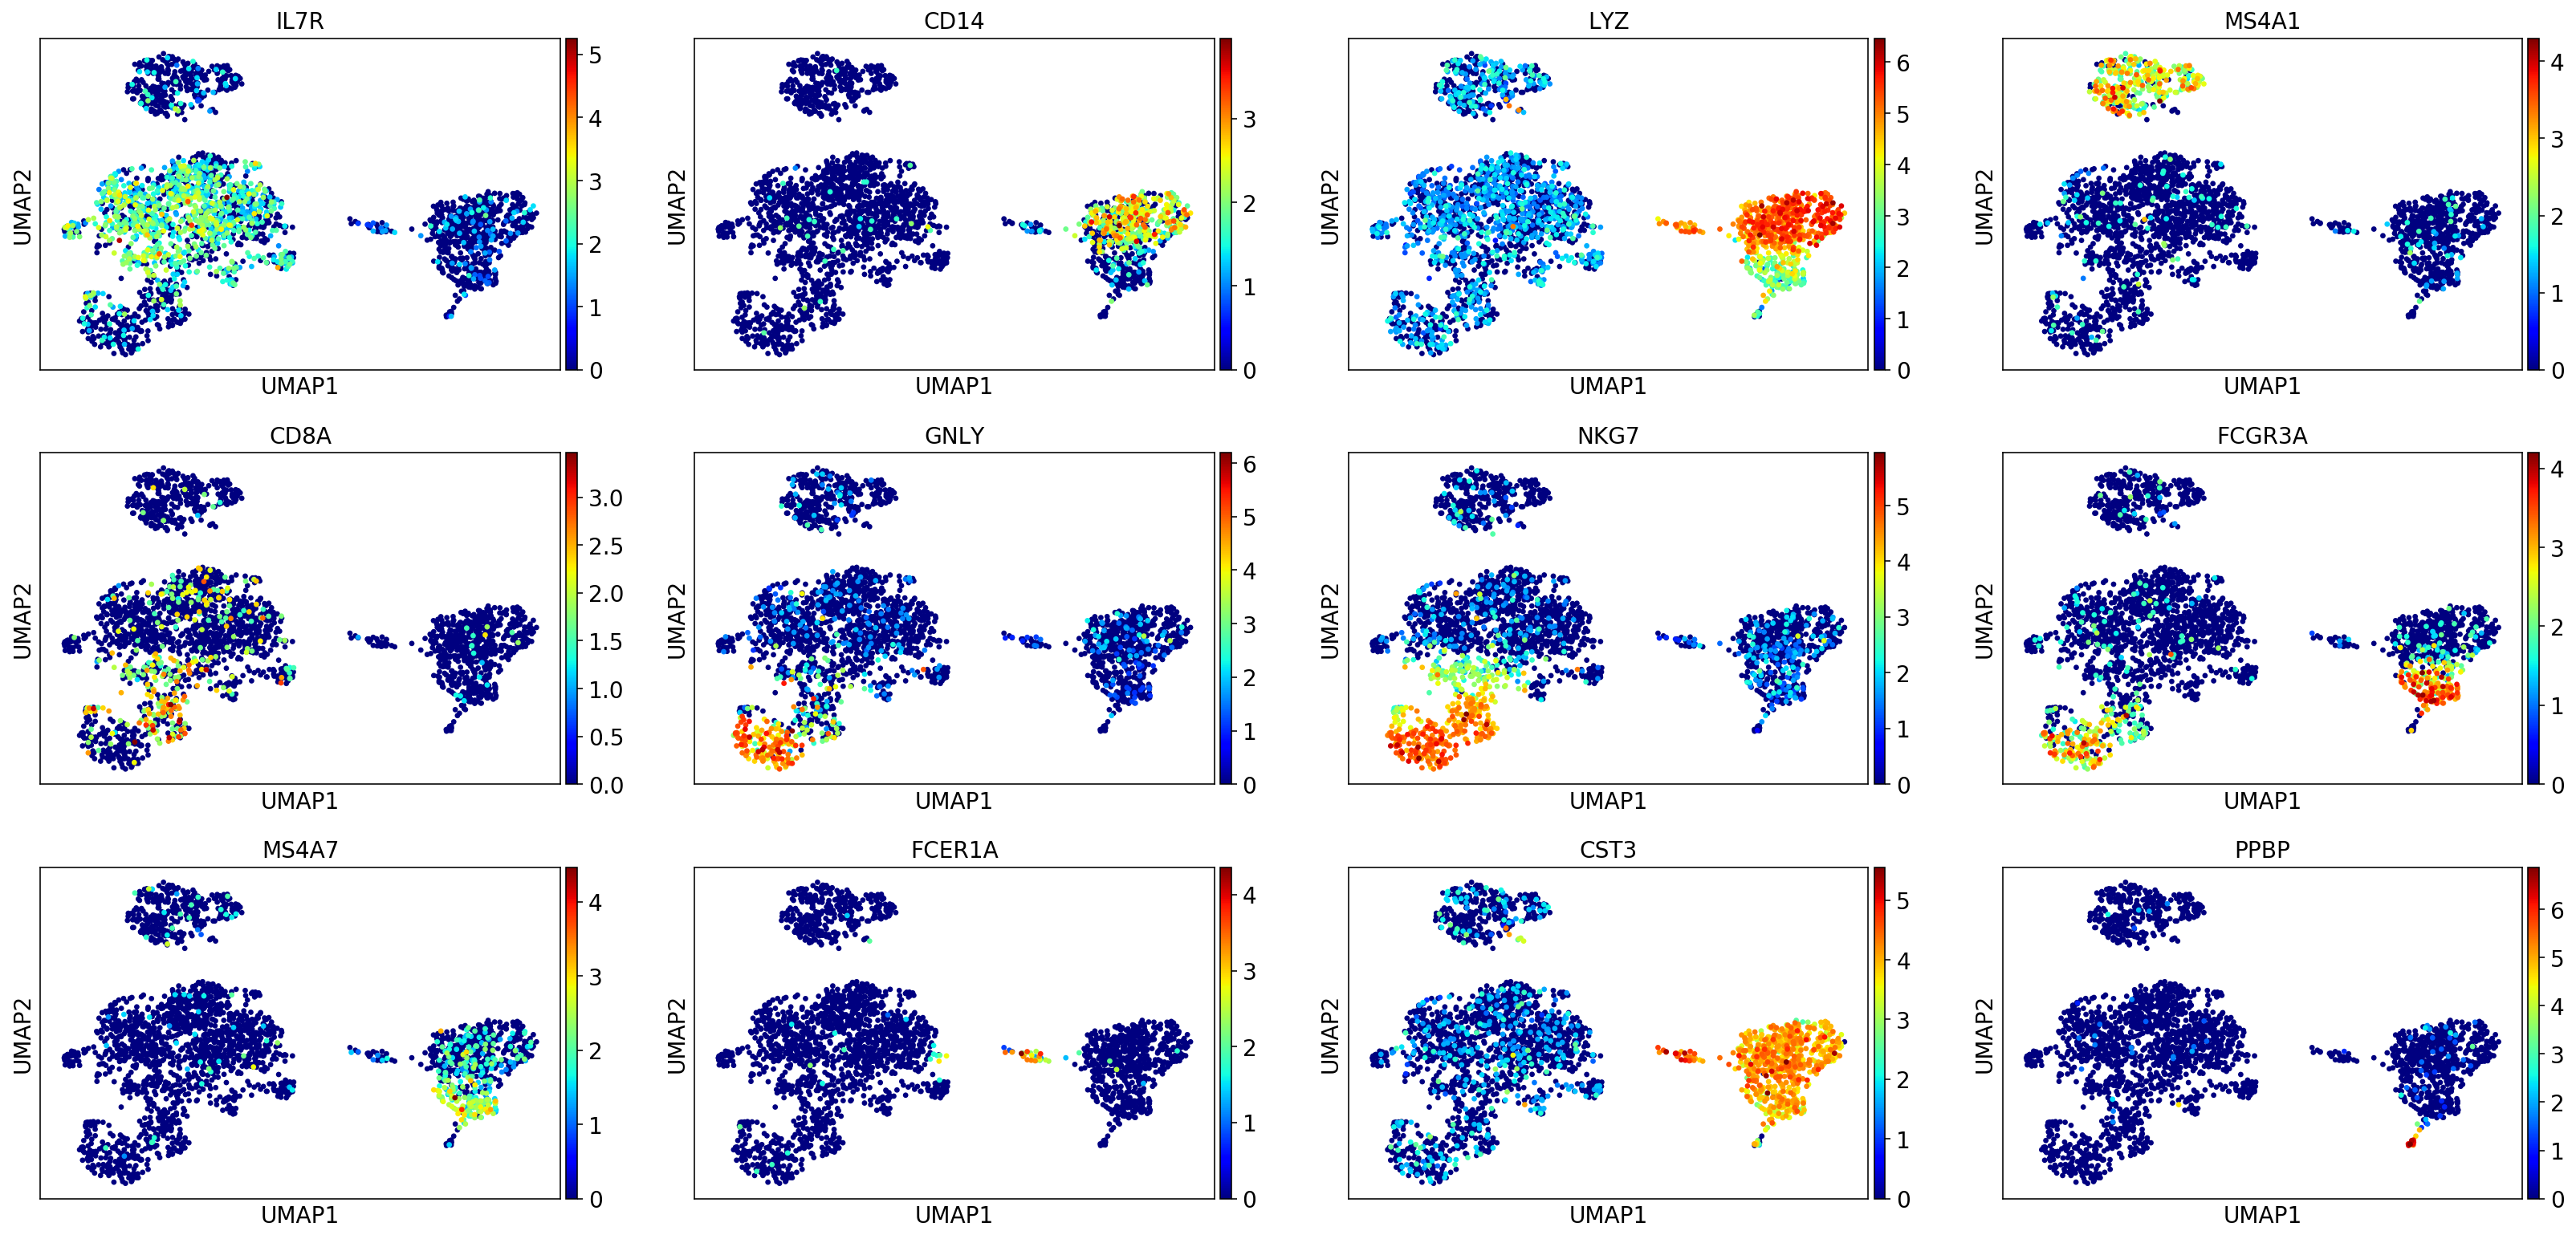

In [8]:
#Plot the known marker genes
sc.pl.umap(adata,color=['IL7R','CD14','LYZ','MS4A1','CD8A','GNLY', 'NKG7','FCGR3A', 'MS4A7','FCER1A', 'CST3','PPBP'],
                       color_map='jet')

Indeed all the major cell types are still captured. What about the new types and subtypes?

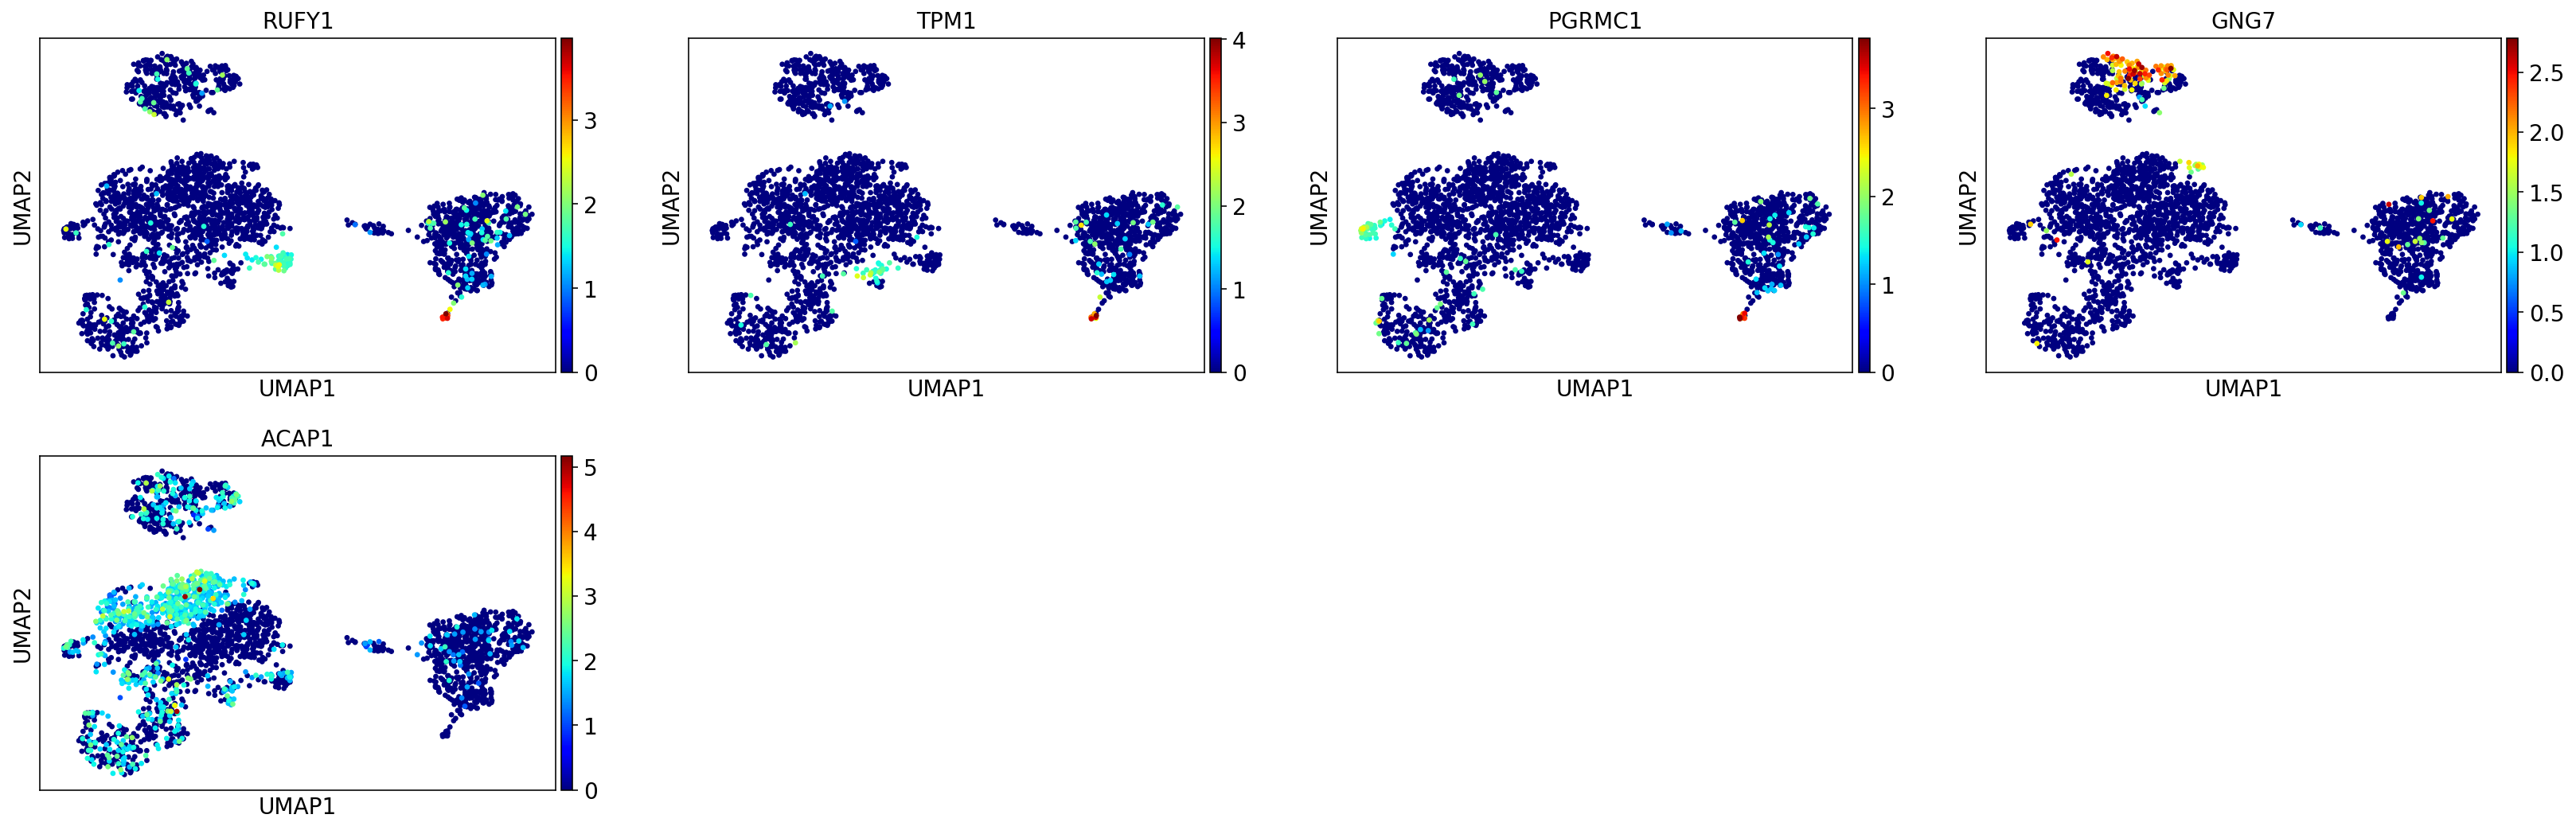

In [9]:
sc.pl.umap(adata,color=['RUFY1','TPM1','PGRMC1','GNG7','ACAP1'],color_map='jet')

It will be interesting to follow the subtle differences between these subclusters to see whether they do have biological meanings